Best: 180 ms, Best Correlation: 0.9306


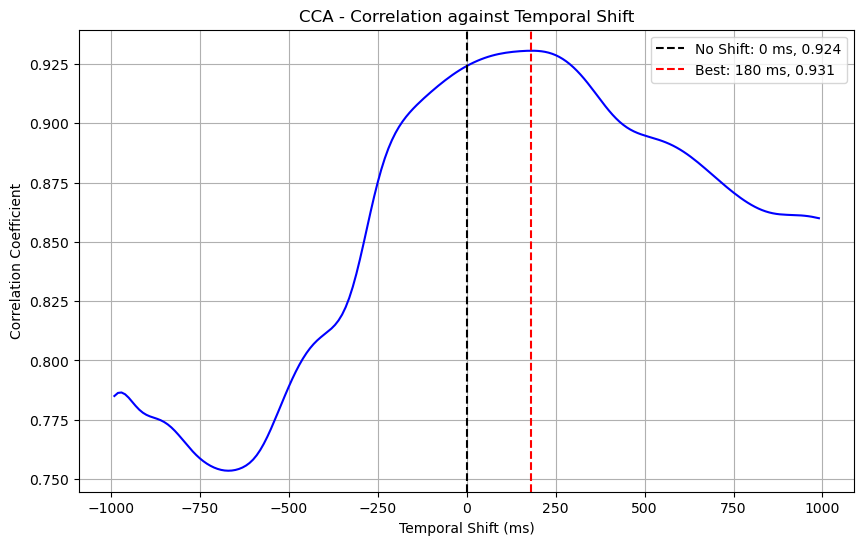

Best: 180 ms, Best Correlation: 0.9306


In [ ]:
import pandas as pd
from sklearn.cross_decomposition import CCA
import numpy as np
import matplotlib.pyplot as plt

# Load the EEG data
eeg_filename = "Theta_Processed/theta_results_all.csv"
eeg_data = pd.read_csv(eeg_filename)

# Load the pupil data
pupil_filename = "Pupil_Processed/pupil_control_all.csv"
pupil_data = pd.read_csv(pupil_filename)

# Extract the memory power columns from the EEG data
electrodes = ['AFz', 'AF3', 'AF4', 'Fz' , 'F1', 'F2', 'F3', 'F4', 'FC3', 'FC1', 'FC2', 'FC4', 'Cz', 'C3', 'C1', 'C2', 'C4']
memory_cols = [f'Mean_Power_Control_{elec}' for elec in electrodes]
eeg_memory_data = eeg_data[memory_cols]

# Downsample the EEG data from 1000 Hz to 100 Hz by averaging every 10 rows
eeg_memory_data_downsampled = eeg_memory_data.groupby(np.arange(len(eeg_memory_data)) // 10).mean().reset_index(drop=True)

# Normalize the pupil data and EEG data
pupil_diameter = (pupil_data['Mean_Diameter'] - pupil_data['Mean_Diameter'].mean()) / pupil_data['Mean_Diameter'].std()
for col in memory_cols:
    eeg_memory_data_downsampled[col] = (eeg_memory_data_downsampled[col] - eeg_memory_data_downsampled[col].mean()) / eeg_memory_data_downsampled[col].std()

# Ensure both datasets have the same number of rows
min_len = min(len(eeg_memory_data_downsampled), len(pupil_diameter))
eeg_memory_data_downsampled = eeg_memory_data_downsampled.iloc[:min_len]
pupil_diameter = pupil_diameter.iloc[:min_len]

# Define temporal shifts in the range of -1 second to 1 second (100 ms steps)
shifts = np.arange(99, -100, -1)  # Shifts from -1 second to +1 second in 10ms increments

# Initialize list to store correlations for each shift
shift_correlations = []

# Loop through each temporal shift and compute CCA
for shift in shifts:
    # Shift EEG data and get the standard data window from index 200 to 1100
    eeg_memory_data_shifted = eeg_memory_data_downsampled[200 + shift:1100 + shift]
    pupil_diameter_standardized = pupil_diameter[200:1100]  # Pupil diameter stays fixed

    # Perform Canonical Correlation Analysis (CCA)
    cca = CCA(n_components=1)  # One canonical component
    cca.fit(eeg_memory_data_shifted, pupil_diameter_standardized)

    # Get canonical weights for EEG and pupil data
    canonical_weights_eeg = cca.x_weights_.flatten()
    canonical_weights_pupil = cca.y_weights_.flatten()

    # Compute the product of linear weights with their respective original vectors
    combined_eeg = eeg_memory_data_shifted @ canonical_weights_eeg
    combined_pupil = pupil_diameter_standardized * canonical_weights_pupil  # Since pupil has 1D, just multiply

    # Calculate Pearson correlation between the combined EEG and pupil data
    pearson_corr = np.corrcoef(combined_eeg, combined_pupil)[0, 1]
    shift_correlations.append(pearson_corr)


# Find the best shift and correlation
best_shift = -shifts[np.argmax(shift_correlations)] * 10 # Convert to milliseconds
best_correlation = max(shift_correlations)
print(f"Best: {best_shift} ms, Best Correlation: {best_correlation:.4f}")

# Get the correlation at 0 ms shift for the label
zero_shift_corr = shift_correlations[np.where(shifts == 0)[0][0]]

# Plot the correlations over the temporal shifts
plt.figure(figsize=(10, 6))
plt.plot(-shifts * 10, shift_correlations, color='b', markersize=0, linestyle='-')
plt.axvline(x=0, color='k', linestyle='--', label=f'No Shift: 0 ms, {zero_shift_corr:.3f}')
plt.axvline(x=best_shift, color='r', linestyle='--', label=f'Best: {best_shift} ms, {best_correlation:.3f}')

# Labels and title
plt.xlabel('Temporal Shift (ms)')
plt.ylabel('Correlation Coefficient')
plt.title('CCA - Correlation against Temporal Shift')
plt.grid(True)
plt.legend()
plt.show()

# Output the best shift and correlation value
print(f"Best: {best_shift} ms, Best Correlation: {best_correlation:.4f}")



Per-electrode CCA weights (sorted by strength, positive only):
Cz 0.5922
FC4 0.4226
FC2 -0.4133
F2 0.2992
C4 -0.2727
FC1 -0.1980
F4 -0.1882
C1 -0.1837
F1 -0.1238
Fz 0.0998
C3 -0.0408
C2 -0.0164
AF3 -0.0119
F3 0.0089
AF4 -0.0087
AFz 0.0076
FC3 -0.0063
Correlation between combined EEG and pupil data: 0.930568909776455


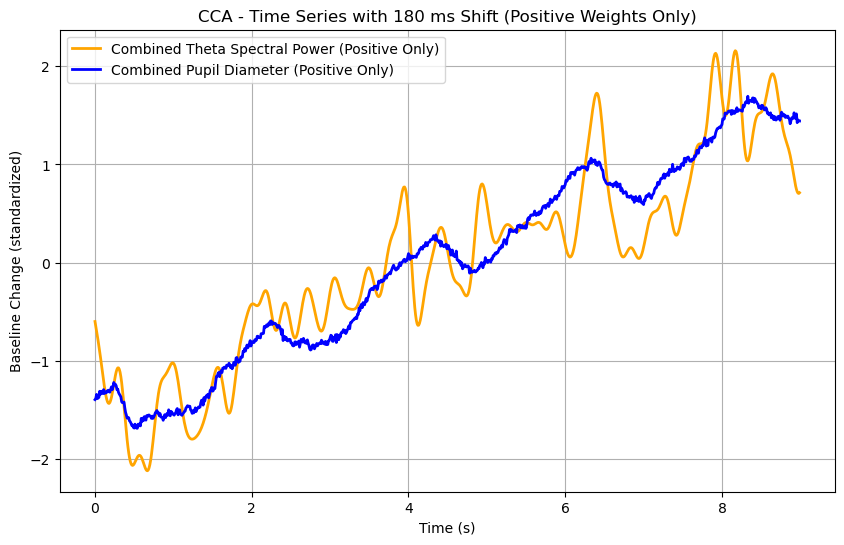

In [2]:
from sklearn.cross_decomposition import CCA
import numpy as np
import matplotlib.pyplot as plt

# Find the best shift as per your existing code
best_shift_idx = np.argmax(shift_correlations)
best_shift = shifts[best_shift_idx]

# Shift EEG
eeg_memory_data_shifted = eeg_memory_data_downsampled[200 + best_shift:1100 + best_shift]
pupil_diameter_standardized = pupil_diameter[200:1100]

# Perform CCA on the best shift
cca = CCA(n_components=1)
cca.fit(eeg_memory_data_shifted, pupil_diameter_standardized)

# Get the canonical weights for EEG and pupil data
canonical_weights_pupil = cca.y_weights_.flatten()
canonical_weights_eeg = cca.x_weights_.flatten()

# Sort electrodes by absolute value of the adjusted CCA weights for EEG
sorted_weights = sorted(zip(electrodes, canonical_weights_eeg), key=lambda x: abs(x[1]), reverse=True)

# Print sorted weights by electrode
print("\nPer-electrode CCA weights (sorted by strength, positive only):")
for electrode, weight in sorted_weights:
    print(f"{electrode} {weight:.4f}")

# Compute the product of linear weights with their respective original vectors
combined_eeg = eeg_memory_data_shifted @ canonical_weights_eeg
combined_pupil = pupil_diameter_standardized * canonical_weights_pupil

# Standardize both combined signals to have the same scale
combined_eeg = (combined_eeg - np.mean(combined_eeg)) / np.std(combined_eeg)
combined_pupil = (combined_pupil - np.mean(combined_pupil)) / np.std(combined_pupil)

# Calculate the correlation to check for positive relationship
print("Correlation between combined EEG and pupil data:", np.corrcoef(combined_eeg, combined_pupil)[0, 1])

# Create a time axis for the plot
time_axis = np.arange(len(combined_eeg))

# Plot the combined EEG and pupil data
plt.figure(figsize=(10, 6))
plt.plot(time_axis / 100, combined_eeg, label='Combined Theta Spectral Power (Positive Only)', color='orange', linestyle='-', linewidth=2)
plt.plot(time_axis / 100, combined_pupil, label='Combined Pupil Diameter (Positive Only)', color='b', linestyle='-', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Baseline Change (standardized)')
plt.title(f'CCA - Time Series with {-best_shift * 10} ms Shift (Positive Weights Only)')
plt.legend()
plt.grid(True)
plt.show()


Best: 300 ms, Best Correlation: 0.9093


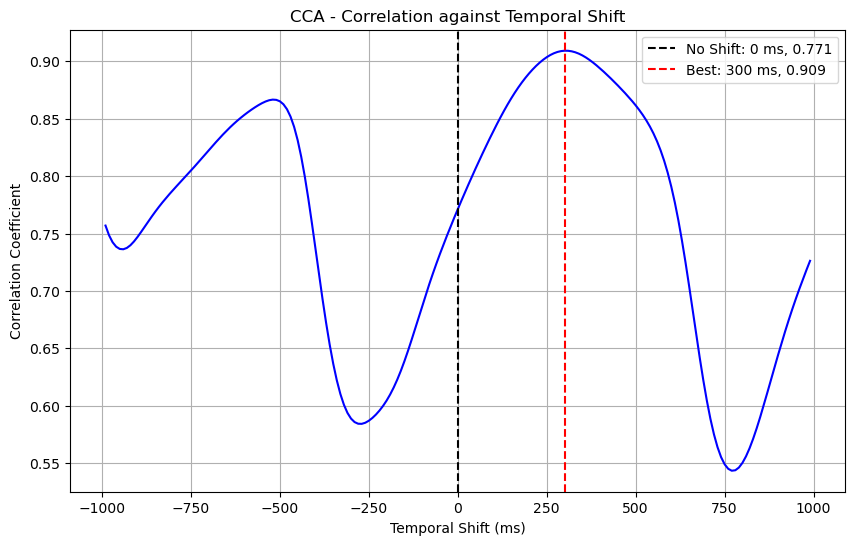

Best: 300 ms, Best Correlation: 0.9093


In [4]:
import pandas as pd
from sklearn.cross_decomposition import CCA
import numpy as np
import matplotlib.pyplot as plt

# Load the EEG data
eeg_filename = "Theta_Processed/theta_results_all.csv"
eeg_data = pd.read_csv(eeg_filename)

# Load the pupil data
pupil_filename = "Pupil_Processed/pupil_memory_all.csv"
pupil_data = pd.read_csv(pupil_filename)

# Extract the memory power columns from the EEG data
electrodes = ['AFz', 'AF3', 'AF4', 'Fz' , 'F1', 'F2', 'F3', 'F4', 'FC3', 'FC1', 'FC2', 'FC4', 'Cz', 'C3', 'C1', 'C2', 'C4']
memory_cols = [f'Mean_Power_Memory_{elec}' for elec in electrodes]
eeg_memory_data = eeg_data[memory_cols]

# Downsample the EEG data from 1000 Hz to 100 Hz by averaging every 10 rows
eeg_memory_data_downsampled = eeg_memory_data.groupby(np.arange(len(eeg_memory_data)) // 10).mean().reset_index(drop=True)

# Normalize the pupil data and EEG data
pupil_diameter = (pupil_data['Mean_Diameter'] - pupil_data['Mean_Diameter'].mean()) / pupil_data['Mean_Diameter'].std()
for col in memory_cols:
    eeg_memory_data_downsampled[col] = (eeg_memory_data_downsampled[col] - eeg_memory_data_downsampled[col].mean()) / eeg_memory_data_downsampled[col].std()

# Ensure both datasets have the same number of rows
min_len = min(len(eeg_memory_data_downsampled), len(pupil_diameter))
eeg_memory_data_downsampled = eeg_memory_data_downsampled.iloc[:min_len]
pupil_diameter = pupil_diameter.iloc[:min_len]

# Define temporal shifts in the range of -1 second to 1 second (100 ms steps)
shifts = np.arange(99, -100, -1)  # Shifts from -1 second to +1 second in 10ms increments

# Initialize list to store correlations for each shift
shift_correlations = []

# Loop through each temporal shift and compute CCA
for shift in shifts:
    # Shift EEG data and get the standard data window from index 200 to 1100
    eeg_memory_data_shifted = eeg_memory_data_downsampled[200 + shift:1100 + shift]
    pupil_diameter_standardized = pupil_diameter[200:1100]  # Pupil diameter stays fixed

    # Perform Canonical Correlation Analysis (CCA)
    cca = CCA(n_components=1)  # One canonical component
    cca.fit(eeg_memory_data_shifted, pupil_diameter_standardized)

    # Get canonical weights for EEG and pupil data
    canonical_weights_eeg = cca.x_weights_.flatten()
    canonical_weights_pupil = cca.y_weights_.flatten()
    
    # Compute the product of linear weights with their respective original vectors
    combined_eeg = eeg_memory_data_shifted @ canonical_weights_eeg
    combined_pupil = pupil_diameter_standardized * canonical_weights_pupil  # Since pupil has 1D, just multiply

    # Calculate Pearson correlation between the combined EEG and pupil data
    pearson_corr = np.corrcoef(combined_eeg, combined_pupil)[0, 1]
    shift_correlations.append(pearson_corr)

# Find the best shift and correlation
best_shift = -shifts[np.argmax(shift_correlations)] * 10
best_correlation = max(shift_correlations)
print(f"Best: {best_shift} ms, Best Correlation: {best_correlation:.4f}")

# Get the correlation at 0 ms shift for the label
zero_shift_corr = shift_correlations[np.where(shifts == 0)[0][0]]

# Plot the correlations over the temporal shifts
plt.figure(figsize=(10, 6))
plt.plot(-shifts * 10, shift_correlations, color='b', markersize=0, linestyle='-')
plt.axvline(x=0, color='k', linestyle='--', label=f'No Shift: 0 ms, {zero_shift_corr:.3f}')
plt.axvline(x=best_shift, color='r', linestyle='--', label=f'Best: {best_shift} ms, {best_correlation:.3f}')

# Labels and title
plt.xlabel('Temporal Shift (ms)')
plt.ylabel('Correlation Coefficient')
plt.title('CCA - Correlation against Temporal Shift')
plt.grid(True)
plt.legend()
plt.show()

# Output the best shift and correlation value
print(f"Best: {best_shift} ms, Best Correlation: {best_correlation:.4f}")



Per-electrode CCA weights (sorted by strength, positive only):
AF4 0.6857
F4 -0.5196
F1 -0.2404
Fz 0.2358
F2 0.2295
Cz -0.1321
AFz -0.1245
F3 -0.1176
C1 -0.1119
C2 0.1111
FC3 0.0779
FC1 0.0774
AF3 -0.0642
FC4 0.0541
C4 0.0390
FC2 -0.0360
C3 -0.0119
Correlation between combined EEG and pupil data: 0.9092933795356691


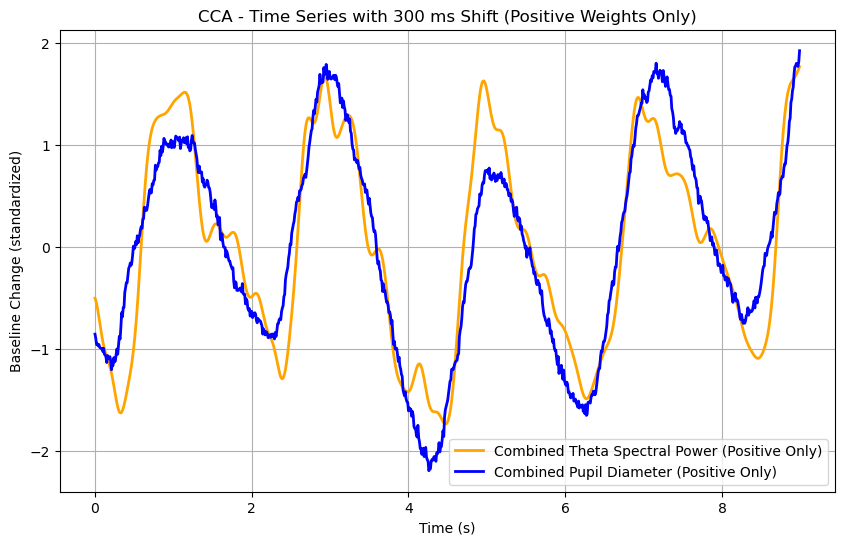

In [5]:
from sklearn.cross_decomposition import CCA
import numpy as np
import matplotlib.pyplot as plt

# Find the best shift as per your existing code
best_shift_idx = np.argmax(shift_correlations)
best_shift = shifts[best_shift_idx]

# Shift EEG
eeg_memory_data_shifted = eeg_memory_data_downsampled[200 + best_shift:1100 + best_shift]
pupil_diameter_standardized = pupil_diameter[200:1100]

# Perform CCA on the best shift
cca = CCA(n_components=1)
cca.fit(eeg_memory_data_shifted, pupil_diameter_standardized)

# Get the canonical weights for EEG and pupil data
canonical_weights_pupil = cca.y_weights_.flatten()
canonical_weights_eeg = cca.x_weights_.flatten()

# Sort electrodes by absolute value of the adjusted CCA weights for EEG
sorted_weights = sorted(zip(electrodes, canonical_weights_eeg), key=lambda x: abs(x[1]), reverse=True)

# Print sorted weights by electrode
print("\nPer-electrode CCA weights (sorted by strength, positive only):")
for electrode, weight in sorted_weights:
    print(f"{electrode} {weight:.4f}")

# Compute the product of linear weights with their respective original vectors
combined_eeg = eeg_memory_data_shifted @ canonical_weights_eeg
combined_pupil = pupil_diameter_standardized * canonical_weights_pupil

# Standardize both combined signals to have the same scale
combined_eeg = (combined_eeg - np.mean(combined_eeg)) / np.std(combined_eeg)
combined_pupil = (combined_pupil - np.mean(combined_pupil)) / np.std(combined_pupil)

# Calculate the correlation to check for positive relationship
print("Correlation between combined EEG and pupil data:", np.corrcoef(combined_eeg, combined_pupil)[0, 1])

# Create a time axis for the plot
time_axis = np.arange(len(combined_eeg))

# Plot the combined EEG and pupil data
plt.figure(figsize=(10, 6))
plt.plot(time_axis / 100, combined_eeg, label='Combined Theta Spectral Power (Positive Only)', color='orange', linestyle='-', linewidth=2)
plt.plot(time_axis / 100, combined_pupil, label='Combined Pupil Diameter (Positive Only)', color='b', linestyle='-', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Baseline Change (standardized)')
plt.title(f'CCA - Time Series with {-best_shift * 10} ms Shift (Positive Weights Only)')
plt.legend()
plt.grid(True)
plt.show()
